$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\Tr}[0]{^\top}
\newcommand{\softmax}[1]{\mathrm{softmax}\left({#1}\right)}
$$

# CS236781: Deep Learning
# Tutorial 7: Enc/Dec arch, Seq2Seq, Attention

## Introduction


In this tutorial, we will cover:

TODO

In [1]:
# Setup
%matplotlib inline
import os
import sys
import math
import time
import tqdm
import torch
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Theory reminders

- RNNs
- GRU
- Encoder/decoder, generative models
- Attention

In the context of learning from **sequences** of inputs, we have seen RNNs as a model capable of learning a transformation of one sequence into another.

<center><img src="img/rnn_unrolled.png" width="1000" /></center>


Where,

$$
\begin{align}
\forall t \geq 0:\\
\vec{h}_t &= \varphi_h\left( \mat{W}_{hh} \vec{h}_{t-1} + \mat{W}_{xh} \vec{x}_t + \vec{b}_h\right) \\
\vec{y}_t &= \varphi_y\left(\mat{W}_{hy}\vec{h}_t + \vec{b}_y \right)
\end{align}
$$

However, RNNs (even the fancy ones) have some major drawbacks:

1. Input must be processed sequentially.
2. Hard to train on long sequences (needs BPTT).
3. Difficult to learn long-term dependencies, e.g. between late outputs and early inputs. The **hidden state** has the burden of "remembering" the "meaning" of the entire sequence so far.

## Part 1: Sequence-to-sequence machine translation

Imagine we want to translate text from English to French. The general approach using RNNs is to design a Sequence-to-sequence (**Seq2Seq**) Encoder-Decoder architecture:

<center><img src="img/seq2seq.svg" width="1000" /></center>

In [3]:
from torchtext.datasets import Multi30k
from torchtext.data import Field

# Common args for field objects
field_args = dict(tokenize='spacy',
                  init_token = '<sos>',
                  eos_token = '<eos>',
                  include_lengths=True,
                  lower = True) 

# Field for processing German source
src_field = Field(tokenizer_language="de_core_news_sm", **field_args)

# Field for processing English target
tgt_field = Field(tokenizer_language="en_core_web_sm", **field_args)

In [4]:
ds_train, ds_valid, ds_test = Multi30k.splits(
    root=data_dir, exts=('.de', '.en'), fields=(src_field, tgt_field)
)

VOCAB_MIN_FREQ = 2
src_field.build_vocab(ds_train, min_freq=VOCAB_MIN_FREQ)
tgt_field.build_vocab(ds_train, min_freq=VOCAB_MIN_FREQ)

In [5]:
V_src = len(src_field.vocab)
print(f'source vocab size: {V_src}')

V_tgt = len(tgt_field.vocab)
print(f'target vocab size: {V_tgt}')

source vocab size: 7855
target vocab size: 5893


In [6]:
for i in ([1, 10, 100, 1000]):
    example = ds_train[i]
    src = str.join(" ", example.src)
    tgt = str.join(" ", example.trg)
    print(f'sample#{i:04d}:\n\tDE: {src}\n\tEN: {tgt}\n')

sample#0001:
	DE: mehrere männer mit schutzhelmen bedienen ein antriebsradsystem .
	EN: several men in hard hats are operating a giant pulley system .

sample#0010:
	DE: eine ballettklasse mit fünf mädchen , die nacheinander springen .
	EN: a ballet class of five girls jumping in sequence .

sample#0100:
	DE: männliches kleinkind in einem roten hut , das sich an einem geländer festhält .
	EN: toddler boy in a red hat holding on to some railings .

sample#1000:
	DE: ein junger mann in einem weißen hemd , der tomaten schneidet .
	EN: a young man in a white shirt cutting tomatoes .



In [7]:
tgt_field.vocab.itos[0:10]

['<unk>', '<pad>', '<sos>', '<eos>', 'a', '.', 'in', 'the', 'on', 'man']

In [8]:
src_field.vocab.itos[0:10]

['<unk>', '<pad>', '<sos>', '<eos>', '.', 'ein', 'einem', 'in', 'eine', ',']

In [9]:
UNK_TOKEN = tgt_field.vocab.stoi['<unk>']
PAD_TOKEN = tgt_field.vocab.stoi['<pad>']

print(f'<unk>={UNK_TOKEN}, <pad>={PAD_TOKEN}')

<unk>=0, <pad>=1


In [10]:
from torchtext.data import BucketIterator

BATCH_SIZE = 4
dl_train, dl_valid, dl_test = BucketIterator.splits((ds_train, ds_valid, ds_test), batch_size = BATCH_SIZE)

In [11]:
# dataloader returns a Batch object with .src and .trg attributes
b0 = next(iter(dl_train))

# The .src/.trg attributes contain tuples of sequences and their lengths
# Get batches of sequences 
x0, x0_len = b0.src
y0, y0_len =  b0.trg

print('x0:\n', x0, x0.shape)
print('x0_len:\n', x0_len, x0_len.shape)
print('y0:\n', y0, y0.shape)
print('y0_len:\n', y0_len, y0_len.shape)

x0:
 tensor([[   2,    2,    2,    2],
        [   5,    8,    5,    5],
        [3166,   36,  457,  177],
        [  25,   65,  351,   25],
        [ 570,   29,   12,    7],
        [  19,    7,   33,    6],
        [4036,   14, 1955,  102],
        [  85, 3908,    4,   79],
        [   8,   64,    3,   10],
        [1658,    8,    1,    6],
        [  12,  545,    1,   11],
        [   4,  140,    1,  332],
        [   3,    4,    1, 2070],
        [   1,    3,    1,  451],
        [   1,    1,    1,   29],
        [   1,    1,    1,   12],
        [   1,    1,    1,   14],
        [   1,    1,    1,  408],
        [   1,    1,    1,   10],
        [   1,    1,    1, 1374],
        [   1,    1,    1,    7],
        [   1,    1,    1,    5],
        [   1,    1,    1,  312],
        [   1,    1,    1,    4],
        [   1,    1,    1,    3]]) torch.Size([25, 4])
x0_len:
 tensor([13, 14,  9, 25]) torch.Size([4])
y0:
 tensor([[   2,    2,    2,    2],
        [   4,    4,    4,    4],
 

In [133]:
import torch.nn as nn

class Seq2SeqEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, h_dim, dropout=0.2):
        super().__init__()
        
        # nn.Embedding converts from token index to dense tensor
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # PyTorch multilayer GRU RNN
        self.rnn = nn.GRU(embedding_dim, h_dim, num_layers=num_layers, dropout=dropout)
        
    def forward(self, x):
        # x shape: (S, B) Note batch dim is not first!
        S, B = x.shape
        embedded = self.embedding(x) # embedded shape: (S, B, E)
        
        # GRU first  output returns all hidden states from last layer (S, B, H)
        # GRU second output returns last hidden state from each layer (L, B, H)
        h, ht = self.rnn(embedded)
        return h, ht

Test the encoder with a batch of English sentences

In [134]:
EMB_DIM = 128
HID_DIM = 64
NUM_LAYERS = 2

enc = Seq2SeqEncoder(V_src, EMB_DIM, NUM_LAYERS, HID_DIM)
h, ht = enc(x0)
print(f'h: {h.shape}')
print(f'ht: {ht.shape}')

h: torch.Size([25, 4, 64])
ht: torch.Size([2, 4, 64])


In [135]:
class Seq2SeqDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, h_dim, dropout=0.2):
        super().__init__()
        
        # nn.Embedding converts from token index to dense tensor
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # PyTorch multilayer GRU RNN
        self.rnn = nn.GRU(embedding_dim, h_dim, num_layers=num_layers, dropout=dropout)
        
        # Output layer, note the output dimension!
        self.out_fc = nn.Linear(h_dim, vocab_size)
        
    def forward(self, x, context, **kw):
        # x shape: (S, B)
        # context: (L, B, H) the last hidden state from the encoder
        S, B = x.shape
        embedded = self.embedding(x) # embedded shape: (S, B, E)
        
        # Note initial hidden state is the input context vector
        # h:  all hidden states from last layer (S, B, H)
        # ht: last hidden state from each layer (L, B, H)
        h, ht = self.rnn(embedded, context)
        
        # Project H back to the vocab size V, to get a score per word
        out = self.out_fc(h)
        
        # Out shapes: (S, B, V) and (L, B, H)
        return out, ht

Test the decoder with the corresponding batch of German sentences

In [136]:
dec = Seq2SeqDecoder(V_tgt, EMB_DIM, NUM_LAYERS, HID_DIM)
yhat, _ = dec(y0, ht) # note different S
print(f'yhat: {yhat.shape}')

yhat: torch.Size([24, 4, 5893])


In [143]:
class Seq2Seq(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embedding_dim, num_layers, h_dim, **kw):
        super().__init__()
        
        # Create encoder & decoder parts
        self.enc = Seq2SeqEncoder(src_vocab_size, embedding_dim, num_layers, h_dim, **kw)
        self.dec = Seq2SeqDecoder(tgt_vocab_size, embedding_dim, num_layers, h_dim, **kw)
    
    def forward(self, x_src, x_tgt, p_tf=1.):
        # input shapes: (S1, B), (S2, B)
        S2, B = x_tgt.shape
        
        # Forward pass through encoder
        # context is (L, B, H)
        enc_h, context = self.enc(x_src)
        
        # First input is first target token
        dec_input = x_tgt[[0], :] # (1, B)
        # Loop over tokens in target sequence and feed them to the decoder
        dec_outputs = []
        for t in range(1, S2):
            # Feed the decoder sequences of length 1
            dec_output, context = self.dec(dec_input, context, enc_h=enc_h) # dec_output is (1, B, V)
            dec_outputs.append(dec_output)
            
            # For next input, take either:
            # - next target token (AKA "teacher forcing"), with proba p_tf
            # - highest scoring output (greedy prediction of next token), with proba 1-p_tf
            if p_tf > torch.rand(1).item():
                dec_input = x_tgt[[t], :] # (1, B)
            else:
                dec_input = torch.argmax(dec_output, dim=2) # (1,B,V) -> (1, B)
            
        # Stack decoder outputs from all timesteps
        y_hat = torch.cat(dec_outputs, dim=0) # (S-1)x(1,B,V) -> (S-1,B,V)
        
        # Output shape: (S-1, B, V)
        return y_hat

In [144]:
seq2seq_model = Seq2Seq(V_src, V_tgt, EMB_DIM, NUM_LAYERS, HID_DIM)
yhat = seq2seq_model(x0, y0)
print(yhat.shape)

torch.Size([23, 4, 5893])


In [145]:
def train_seq2seq(model, dl_train, optimizer, loss_fn, p_tf=1., clip_grad=1., max_batches=None):
    losses = []
    with tqdm.tqdm(total=(max_batches if max_batches else len(dl_train)), file=sys.stdout) as pbar:
        for idx_batch, batch in enumerate(dl_train, start=1):
            x, x_len = batch.src
            y, y_len =  batch.trg

            # Forward pass: encoder and decoder
            # Output y_hat is the translated sequence
            y_hat = model(x, y, p_tf)
            S, B, V = y_hat.shape

            # y[:,i] is <sos>, w_1, w_2, ..., w_k, <eos>, <pad>, ...
            # y_hat is   w_1', w_2', ..., w_k', <eos>', <pad>', ...
            # based on the above, get ground truth y
            y_gt = y[1:, :].reshape(S*B)  # drop <sos>
            y_hat = y_hat.reshape(S*B, V)

            # Calculate loss compared to ground truth y
            optimizer.zero_grad()
            loss = loss_fn(y_hat, y_gt)
            loss.backward()

            # Prevent exploding gradients
            if clip_grad > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

            # Update parameters
            optimizer.step()

            losses.append(loss.item())
            pbar.update(); pbar.set_description(f'train loss={losses[-1]:.3f}')
            if max_batches and idx_batch >= max_batches:
                break
    return losses

In [146]:
def eval_seq2seq(model, dl_test):
    accuracies = []
    with tqdm.tqdm(total=len(dl_test), file=sys.stdout) as pbar:
        for idx_batch, batch in enumerate(dl_test):
            x, x_len = batch.src
            y, y_len =  batch.trg

            with torch.no_grad():
                y_hat = model(x, y, p_tf=0)  # Note: no teacher forcing

            S, B, V = y_hat.shape

            y_gt = y[1:, :].reshape(S*B)  # drop <sos>
            y_hat = torch.argmax(y_hat.reshape(S*B, V), dim=1) # greedy-sample

            # Compare prediction to ground truth
            accuracies.append(torch.sum(y_gt == y_hat) / S)

            pbar.update(); pbar.set_description(f'eval acc={accuracies[-1]}')
    return accuracies

In [147]:
BATCH_SIZE = 128
# Use small model so that training is fast, just an example
EMB_DIM = 64
HID_DIM = 128
NUM_LAYERS = 3
GRAD_CLIP = 1.
EPOCHS = 2
BATCHES_PER_EPOCH=25

dl_train, dl_valid, dl_test = BucketIterator.splits((ds_train, ds_valid, ds_test), batch_size=BATCH_SIZE)
seq2seq_model = Seq2Seq(V_src, V_tgt, EMB_DIM, NUM_LAYERS, HID_DIM)

optimizer = torch.optim.Adam(seq2seq_model.parameters(), lr=1e-2)

# Note: We don't compute loss from padding tokens!
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

losses = []
accuracies = []
for idx_epoch in range(EPOCHS):
    # Linearly decay amount of teacher forcing for the first 20 epochs (example)
    p_tf = 1 - min((idx_epoch / 20), 1)
    
    print(f'=== EPOCH {idx_epoch+1}/{EPOCHS}, p_tf={p_tf:.2f} ===')
    losses += train_seq2seq(seq2seq_model, dl_train, optimizer, loss_fn, p_tf, GRAD_CLIP, BATCHES_PER_EPOCH)
    accuracies += eval_seq2seq(seq2seq_model, dl_valid)

=== EPOCH 1/2, p_tf=1.00 ===
eval acc=7: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s] 
=== EPOCH 2/2, p_tf=0.95 ===
eval acc=9: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s] 


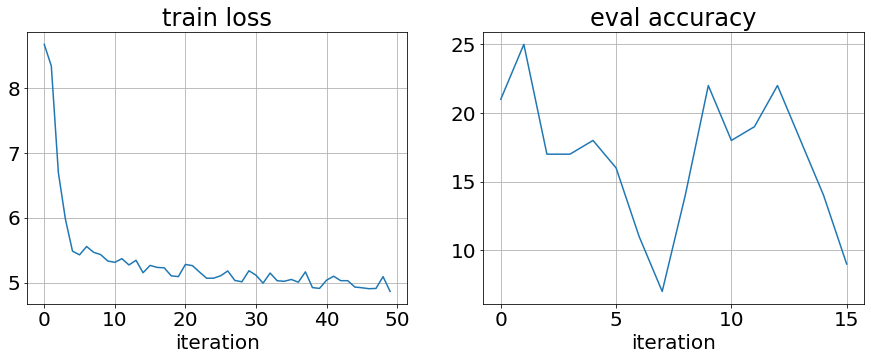

In [148]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(losses); ax[0].set_title('train loss'); ax[0].set_xlabel('iteration'); ax[0].grid(True)
ax[1].plot(accuracies); ax[1].set_title('eval accuracy'); ax[1].set_xlabel('iteration'); ax[1].grid(True)

Can we use this a **Generative** model?

I.e., can we use this model to generate coherent sentences in English?

Theoretically we could... But how can we sample the input context vector?

## Part 2: Attention Mechanisms

In such an architecture the **last** hidden state must encode all the information the decoder needs for translation.

**Local** information, i.e. the encoder outputs and intermediate hidden states is discarded.

Can we use this local info to help the decoder?

### Definition

In deep learning contexts, **attention** is a term used for a family of related mechanisms which, in general, learn to predict some probability distribution over a sequence of elements.

Intuitively, this allows a model to "pay more attention" to elements from the sequence which get a higher probability.

Recent versions of attention mechanisms can be defined formally as follows:

Given:
- $n$ **key-value** pairs: $\left\{\left(\vec{k}_i, \vec{v}_i\right)\right\}_{i=1}^{n}$, where $\vec{k}_i\in\set{R}^{d_k}$, $\vec{v}_i\in\set{R}^{d_v}$
- A **query**, $\vec{q} \in\set{R}^{d_q}$
- Some similarity (sometimes called *energy*) function between keys and queries, $s: \set{R}^{d_k}\times \set{R}^{d_q} \mapsto \set{R}$

A *soft*-attention mechanism computes a weighted sum of the **values**,

$$
\vec{o} = \sum_{i=1}^{n} a_i \vec{v}_i\ \in \set{R}^{d_v},
$$

where attention weights $a_i$ are computed according the the similarity between the **query** and each **key**:

$$
\begin{align}
b_i &= s(\vec{k}_i, \vec{q}) \\
\vec{b} &= \left[  b_1, \dots, b_n \right]\Tr \\
\vec{a} &= \softmax{\vec{b}}.
\end{align}
$$


It's also possible to define *hard*-attention by using the weights $\vec{a}$ as a discrete distribution over the values, an sample a single $\vec{v}_i$ from this distribution:

$$
\vec{o} \sim p_\vec{a}(\vec{v})
$$

In this case the attention output is stochastic.

### Multiplicative attention

One basic type of attention mechanism uses a simple **dot product** as the similarity function.

Widely-used by models based on the **Transformer** architecture.

Assume $d_k=d_q=d$, then

$$
s(\vec{k},\vec{q})= \frac{\vectr{k}\vec{q}}{\sqrt{d}}.
$$

Why scale by $\sqrt{d}$ ?

It's the factor at which the dot-product grows due to the dimensionality. E.g.,

$$
\norm{\vec{1}_d}_2 = \norm{[1,\dots,1]\Tr}_2 = \sqrt{d\cdot 1^2} =\sqrt{d}.
$$

This helps keep the softmax values from becoming very small when the dimension is large, and therefore helps prevent tiny gradients.

Let's now deal with $m$ queries simultaneously by stacking them in a matrix $\mat{Q} \in \set{R}^{m\times d}$.

Similarly, we'll stack the keys and values in their own matrices, $\mat{K}\in\set{R}^{n\times d}$, $\mat{V}\in\set{R}^{n\times d_v}$.

Then we can compute the attention weights for all queries in parallel:

$$
\begin{align}
\mat{B} &= \frac{1}{\sqrt{d}} \mat{Q}\mattr{K}  \ \in\set{R}^{m\times n} \\
\mat{A} &= \softmax{\mat{B}},\ \mathrm{dim}=1 \\
\mat{O} &= \mat{A}\mat{V} \ \in\set{R}^{m\times d_v}.
\end{align}
$$

Note that the softmax is applied per-row, and so each row $i$ of $\mat{A}$ contains the attention weights for the $i$th query.

Also notice that in this formulation, we **input a sequence** of $m$ queries and get an **output sequence** of $m$ weighed values.

### Additive attention

Another common type of attention mechanism uses an MLP to **learn** the similarity function $s(\vec{k},\vec{q})$.

In this type of attention, the similarity function is 

$$
s(\vec{k},\vec{q}) = \vectr{v} \tanh(\mat{W}_k\vec{k} + \mat{W}_q\vec{q}),
$$

where $\mat{W}_k\in\set{R}^{h\times d_k}$, $\mat{W}_q\in\set{R}^{h\times d_q}$ and $\vec{v}\in\set{R}^{h}$ are trainable parameters.

- Notice that we're adding projected versions of the key and query and applying a 2-layer MLP.
- Both projections and the output layer are trainable.

### Self-Attention

Self-attention refers to applying attention on a **single sequence**  $\left\{\vec{x}_i\right\}_{i=1}^{n}$ of elements.

The keys, values and queries are either:
- The elements themselves
- Computed from them with **learned** linear projections, i.e.
$$
\begin{align*}
\vec{q}_{i} &= \mat{W}_{xq}\vec{x}_{i} &
\vec{k}_{i} &= \mat{W}_{xk}\vec{x}_{i} &
\vec{v}_{i} &= \mat{W}_{xv}\vec{x}_{i} 
\end{align*}
$$
This is what Transformer models do for Seq2Seq, instead of using RNNs.

<center><img src="img/self_attn_transformer.svg" width=800></center>

Let's implement an Additive attention layer

In [149]:

def valid_softmax(X: Tensor, valid_len: Tensor=None):
    """
    Applies softmax over last dim of X.
    If valid_len is not none, then it specifies the number of elements to apply the softmax to.
    """
    assert valid_len.ndim == 1
    assert X.shape[0] == valid_len.shape[0]
    
    if valid_len is not None:
        S = X.shape[-1]

        # idx is same shape as X, last dim will contain indices 0...S-1
        idx = torch.arange(S).expand_as(X)

        # Add multiple singleton dims at the end of valid_len,
        # so that ndims is same as X
        valid_len = valid_len[(None,)*(X.ndim-1)].transpose(0, -1)

        # For every index after valid len, we set the mask to True
        mask = idx >= valid_len
        
        # Set masked elements to -inf for softmax
        X = X.to(torch.float)
        X[mask] = float('-inf')
    
    return torch.softmax(X, dim=-1)
    

In [150]:
from torch import Tensor

class MLPAttention(nn.Module):
    def __init__(self, q_dim, k_dim, v_dim, h_dim, dropout=0.):
        super().__init__()
        self.wk = nn.Linear(k_dim, h_dim, bias=False)
        self.wq = nn.Linear(q_dim, h_dim, bias=False)
        self.v  = nn.Linear(h_dim, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q: Tensor, k: Tensor, v: Tensor, valid_len: Tensor=None):
        """
        :param q: Queries tensor of shape (B, Q, q_dim)
        :param k: Keys tensor of shape (B, K, k_dim)
        :param v: Values tensor of shape (B, K, v_dim)
        :param valid_len: Sequence lengths tensor of shape (B,).
        :return: Attended values tensor, of shape (B, Q, v_dim).
        """
        # (B, K, k_dim) -> (B, K, h_dim) -> (B, 1, K, h_dim)
        wk_k = self.wk(k).unsqueeze(1)
        
        # (B, Q, q_dim)  -> (B, Q, h_dim)  -> (B, Q, 1, h_dim)
        wq_q = self.wq(q).unsqueeze(2)
        
        # (B, Q, K, h_dim)
        z1 = torch.tanh(wq_q + wk_k)
        
        # (B, Q, K, 1) -> (B, Q, K)
        z2 = self.v(z1).squeeze(dim=-1)
        
        # a = valid_softmax3d(z2, valid_len)
        # Note: no masking
        a = torch.softmax(z2, dim=-1)
        a = self.dropout(a)
        
        # (B, Q, K) * (B, K, v_dim) = (B, Q, v_dim)
        return torch.bmm(a, v)

<center><img src="img/seq2seq_attention.svg" width=1000></center>

In [151]:
class Seq2SeqDecoderAttn(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, h_dim, dropout=0.2):
        super().__init__()
        # nn.Embedding converts from token index to dense tensor
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Since we'll apply self-attention, the Q, K, V dims are all h_dim
        self.attn = MLPAttention(h_dim, h_dim, h_dim, h_dim, dropout)
        
        # Note: GRU input dim now includes both embedding and attention output!
        self.rnn = nn.GRU(embedding_dim + h_dim*num_layers, h_dim, num_layers=num_layers, dropout=dropout)
        
        # Output layer, note the output dimension!
        self.out_fc = nn.Linear(h_dim, vocab_size)
        
    def forward(self, x, h0, enc_h):
        # x shape: (S, B)
        # h0: (L, B, H) the initial hidden state
        # enc_h: (S, B, H) all outputs from encoder (key-values for attention)
        S, B = x.shape
        embedded = self.embedding(x) # embedded shape: (S, B, E)
        
        # Apply attention
        q  = h0.transpose(0, 1)    # (B, L, H)
        kv = enc_h.transpose(0, 1) # (B, S, H)
        a  = self.attn(q, kv, kv)  # (B, L, H)
        
        # Create RNN input by concatenating attention-based context with the embedded inputs
        # Note that when used with Seq2Seq we have S=1 so the expand is not needed
        # (L, B, H) -> (1, B, L*H) -> (S, B, L*H)
        a = a.reshape(1, B, -1).expand(S, -1, -1)
        rnn_input = torch.cat((embedded, a), dim=2) # (S, B, E + L*H)
        
        h, ht = self.rnn(rnn_input, h0)
        
        # Project H back to the vocab size V, to get a score per word
        out = self.out_fc(h)
        
        # Out shapes: (S, B, V) and (L, B, H)
        return out, ht

In [152]:
class Seq2SeqAttn(Seq2Seq):
    def __init__(self, src_vocab_size, tgt_vocab_size, embedding_dim, num_layers, h_dim, **kw):
        super().__init__(src_vocab_size, tgt_vocab_size, embedding_dim, num_layers, h_dim, **kw)
        
        # Replace decoder
        self.dec = Seq2SeqDecoderAttn(tgt_vocab_size, embedding_dim, num_layers, h_dim, **kw)

In [153]:
BATCH_SIZE = 128
# Use small model so that training is fast, just an example
EMB_DIM = 64
HID_DIM = 128
NUM_LAYERS = 3
GRAD_CLIP = 1.
EPOCHS = 2
BATCHES_PER_EPOCH=25

dl_train, dl_valid, dl_test = BucketIterator.splits((ds_train, ds_valid, ds_test), batch_size=BATCH_SIZE)
seq2seq_model = Seq2SeqAttn(V_src, V_tgt, EMB_DIM, NUM_LAYERS, HID_DIM)

optimizer = torch.optim.Adam(seq2seq_model.parameters(), lr=1e-2)

# Note: We don't compute loss from padding tokens!
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

losses = []
accuracies = []
for idx_epoch in range(EPOCHS):
    # Linearly decay amount of teacher forcing fro the first 10 epochs (example)
    p_tf = 1 - min((idx_epoch / 20), 1)
    
    print(f'=== EPOCH {idx_epoch+1}/{EPOCHS}, p_tf={p_tf:.2f} ===')
    losses += train_seq2seq(seq2seq_model, dl_train, optimizer, loss_fn, p_tf, GRAD_CLIP, BATCHES_PER_EPOCH)
    accuracies += eval_seq2seq(seq2seq_model, dl_valid)

=== EPOCH 1/2, p_tf=1.00 ===
eval acc=8: 100%|██████████| 8/8 [00:02<00:00,  3.50it/s] 
=== EPOCH 2/2, p_tf=0.95 ===
eval acc=8: 100%|██████████| 8/8 [00:02<00:00,  3.47it/s] 


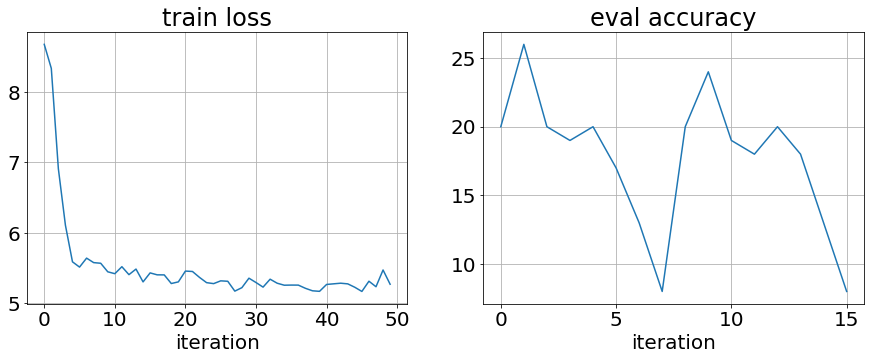

In [154]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(losses); ax[0].set_title('train loss'); ax[0].set_xlabel('iteration'); ax[0].grid(True)
ax[1].plot(accuracies); ax[1].set_title('eval accuracy'); ax[1].set_xlabel('iteration'); ax[1].grid(True)

In [89]:
valid_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5867, 0.4133, 0.0000, 0.0000],
         [0.4991, 0.5009, 0.0000, 0.0000]],

        [[0.2118, 0.3149, 0.4733, 0.0000],
         [0.2448, 0.2945, 0.4607, 0.0000]]])

In [90]:
valid_softmax(torch.rand(2, 4), torch.tensor([2, 3]))

tensor([[0.6714, 0.3286, 0.0000, 0.0000],
        [0.3815, 0.2992, 0.3193, 0.0000]])

In [101]:
valid_softmax(torch.rand(5, 4, 4), torch.tensor([1, 2, 3, 1, 2]))


tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000]],

        [[0.3323, 0.6677, 0.0000, 0.0000],
         [0.6492, 0.3508, 0.0000, 0.0000],
         [0.4705, 0.5295, 0.0000, 0.0000],
         [0.4787, 0.5213, 0.0000, 0.0000]],

        [[0.2665, 0.3629, 0.3706, 0.0000],
         [0.2115, 0.4583, 0.3302, 0.0000],
         [0.3289, 0.4747, 0.1964, 0.0000],
         [0.3541, 0.3875, 0.2585, 0.0000]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000]],

        [[0.6258, 0.3742, 0.0000, 0.0000],
         [0.3414, 0.6586, 0.0000, 0.0000],
         [0.5292, 0.4708, 0.0000, 0.0000],
         [0.5574, 0.4426, 0.0000, 0.0000]]])

In [98]:
valid_softmax(torch.rand(1, 5, 5), torch.arange(1,5+1))


AssertionError: 

In [82]:
# B, Q, K=S
t = torch.ones(3,4,5)
r = torch.arange(5)       # (S,)
v = torch.tensor([1,3,5]) # (B,)

In [83]:
r.expand_as(t)

tensor([[[0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4]],

        [[0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4]],

        [[0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4]]])

In [84]:
vv = v[(None,)*(t.ndim-1)].transpose(0,-1)
vv.shape

torch.Size([3, 1, 1])

In [85]:
vv

tensor([[[1]],

        [[3]],

        [[5]]])

In [86]:
r.expand_as(t).shape

torch.Size([3, 4, 5])

In [87]:
r.expand_as(t) > vv

tensor([[[False, False,  True,  True,  True],
         [False, False,  True,  True,  True],
         [False, False,  True,  True,  True],
         [False, False,  True,  True,  True]],

        [[False, False, False, False,  True],
         [False, False, False, False,  True],
         [False, False, False, False,  True],
         [False, False, False, False,  True]],

        [[False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]]])

In [124]:
torch.ones(1, 3).expand_as(torch.ones(3,3))

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

**Image credits**

Some images in this tutorial were taken and/or adapted from:

- Zhang et al., Dive into Deep Learning, 2019
- Peter Bloem, http://www.peterbloem.nl/blog/transformers
- Sutskever et al. 2014, https://arxiv.org/abs/1409.3215

- MIT 6.S191
- K. Xu et al. 2015, https://arxiv.org/abs/1502.03044